# Timber Harvest

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Helper Functions

In [ ]:
def initialize_all(y0, t0, t, n):
    """
    An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h.
    """
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size)).squeeze()
    else:
        Y = np.empty(n)
    
    Y[0] = y0
    T = np.linspace(t0, t, n)
    h = float(t - t0) / (n - 1)
    return Y, T, h


def RK4(f, y0, t0, t, n):
    """
    Use the RK4 method to compute an approximate solution
    to the ODE y' = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    
    y0 is assumed to be either a constant or a one-dimensional numpy array.
    t and t0 are assumed to be constants.
    f is assumed to accept three arguments.
    The first is a constant giving the value of t.
    The second is a one-dimensional numpy array of the same size as y.
    The third is an index to the other arrays.
    
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i'th value of np.linspace(t0, t, n).
    """
    Y,T,h = initialize_all(y0,t0,t,n)
    for i in range(n-1):
        K1 = f(T[i],Y[i],i)
        K2 = f(T[i]+h/2.,Y[i]+h/2.*K1,i)
        K3 = f(T[i]+h/2.,Y[i]+h/2.*K2,i)
        K4 = f(T[i+1],Y[i]+h*K3,i)
        Y[i+1] = Y[i] + h/6.*(K1+2*K2 +2*K3+K4)
    return Y

This function takes as input scalars $x_{0}$, $k$, $r$, and a final time $T$ and solves an optimal control problem using the RK4 method described above. The function will return the time-step and the values of x and u at the specific time-steps.

In [31]:
def solve_tree_harvest(x0, k, r, T, N=1000, delta=0.001):
    """
    Solves for the optimal control for the tree harvesting problem 
    with the given parameters.
    
    Parameters:
        x0 - initial amount of timber being produced
        k - investment growth rate
        r - interest rate
        T - final time
        N - number of time steps
        delta - error tolerance for convergence
    Returns:
        t ((N+1), ndarray) - timesteps
        x ((N+1), ndarray) - timber production values
        u ((N+1), ndarray) - the optimal control
    """
    t = np.linspace(0,T,N+1)
    h = T/N
    h2 = h/2
    
    x = np.zeros(N+1)
    alpha = np.zeros(N+1)
    u = np.zeros(N+1)
    x[0] = x0
    alpha[-1] = 0
    
    f = lambda x,u: k*u*x
    g = lambda t, alpha, u: u*(np.exp(-r*t) - k*alpha) - np.exp(-r*t)


    
    while True:
        oldx = x.copy()
        oldalpha = alpha.copy()
        oldu = u.copy()

        # Solve for x (iterate through each t (x[t])) (1.2)
        for i in range(N):
            k1 = f(x[i], u[i])
            k2 = f(x[i] + h2*k1, (u[i] + u[i+1])/2)
            k3 = f(x[i] + h2*k2, (u[i] + u[i+1])/2)
            k4 = f(x[i] + h*k3, u[i+1])
            x[i+1] = x[i] + h/6*(k1 + 2*k2 + 2*k3 + k4)
        
        # Solve for alpha (iterate backwords through each t (alpha[t])) (1.5)
        for i in range(N, 0, -1):
            k1 = g(t[i], alpha[i], u[i])
            k2 = g(t[i] - h2, alpha[i] - h2*k1, (u[i] + u[i-1])/2)
            k3 = g(t[i] - h2, alpha[i] - h2*k2, (u[i] + u[i-1])/2)
            k4 = g(t[i] - h, alpha[i] - h*k3, u[i-1])
            alpha[i-1] = alpha[i] - h/6*(k1 + 2*k2 + 2*k3 + k4)

        # Solve for u (iterate through each t u[t]) (1.6 and right below)
        phi = x * (k*alpha - np.exp(-r*t))
        for i in range(N+1):
            if phi[i] > 0:
                u[i] = 1

        # Check for convergence
        if (np.sum(np.abs(oldu - u)) < delta*np.sum(np.abs(u))
            and np.sum(np.abs(oldx - x)) < delta*np.sum(np.abs(x))
            and np.sum(np.abs(oldalpha - alpha)) < delta*np.sum(np.abs(alpha))):
            break
    return t,x,u

# Timber Harvesting

Using the helper functions, we plot time vs. timber production ($x$) and plot time vs. reinvestment percentage ($u$) for the following values: $x_{0} = 100$, $k = 1$, $r = 0$, and $T = 5$.

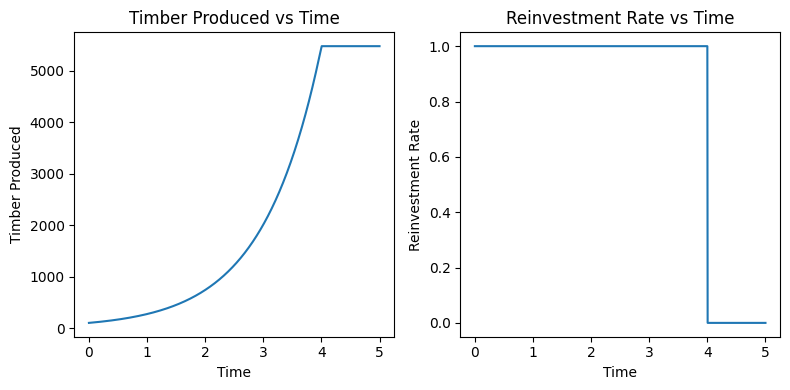

In [33]:
x0 = 100
k = 1
r = 0
T = 5
t, x, u = solve_tree_harvest(x0, k, r, T)

# plot results
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(t, x, label='x')
plt.xlabel('Time')
plt.ylabel("Timber Produced")
plt.title("Timber Produced vs Time")

plt.subplot(122)
plt.plot(t, u, label='u')
plt.xlabel('Time')
plt.ylabel("Reinvestment Rate")
plt.title("Reinvestment Rate vs Time")

plt.tight_layout()
plt.show()

# Alternative Case

We plot the same graphs as before, but instead for the following values: $x_{0} = 100$, $k = 0.3$, $r = 0.05$, and $T = 5$ to see when the switching point changes

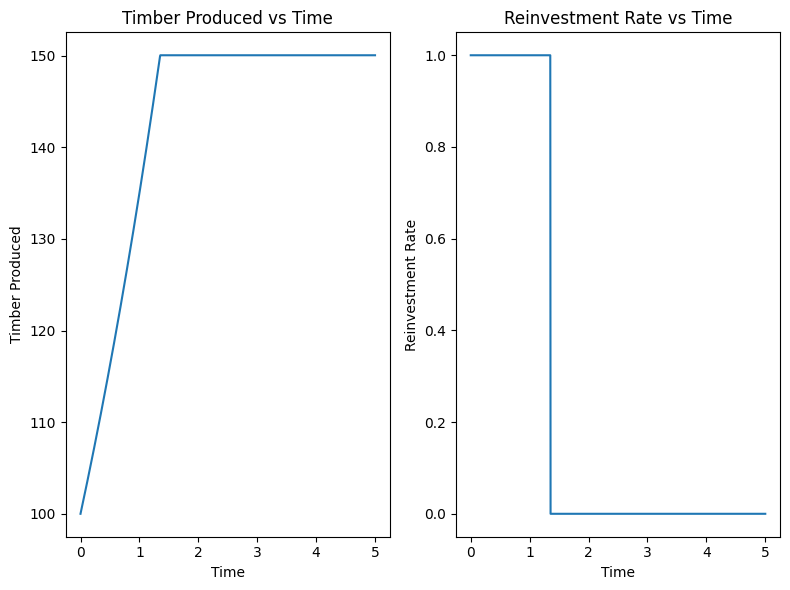

In [34]:
x0 = 100
k = 0.3
r = 0.05
T = 5
t, x, u = solve_tree_harvest(x0, k, r, T)

# plot results
plt.figure(figsize=(8,6))
plt.subplot(121)
plt.plot(t, x, label='x')
plt.xlabel('Time')
plt.ylabel("Timber Produced")
plt.title("Timber Produced vs Time")

plt.subplot(122)
plt.plot(t, u, label='u')
plt.xlabel('Time')
plt.ylabel("Reinvestment Rate")
plt.title("Reinvestment Rate vs Time")

plt.tight_layout()
plt.show()

In [36]:
# find the value of t when u switches from 1 to 0
t_switch = t[np.where(u[:-1] - u[1:] == 1)[0][0]]
print(t_switch)

1.35


The switching point occurs at about 1.35 years.

# Alternative Initial Conditions

We now use the same parameters the previous case, but vary the initial value of the timber production capacity ($x_{0}$). 

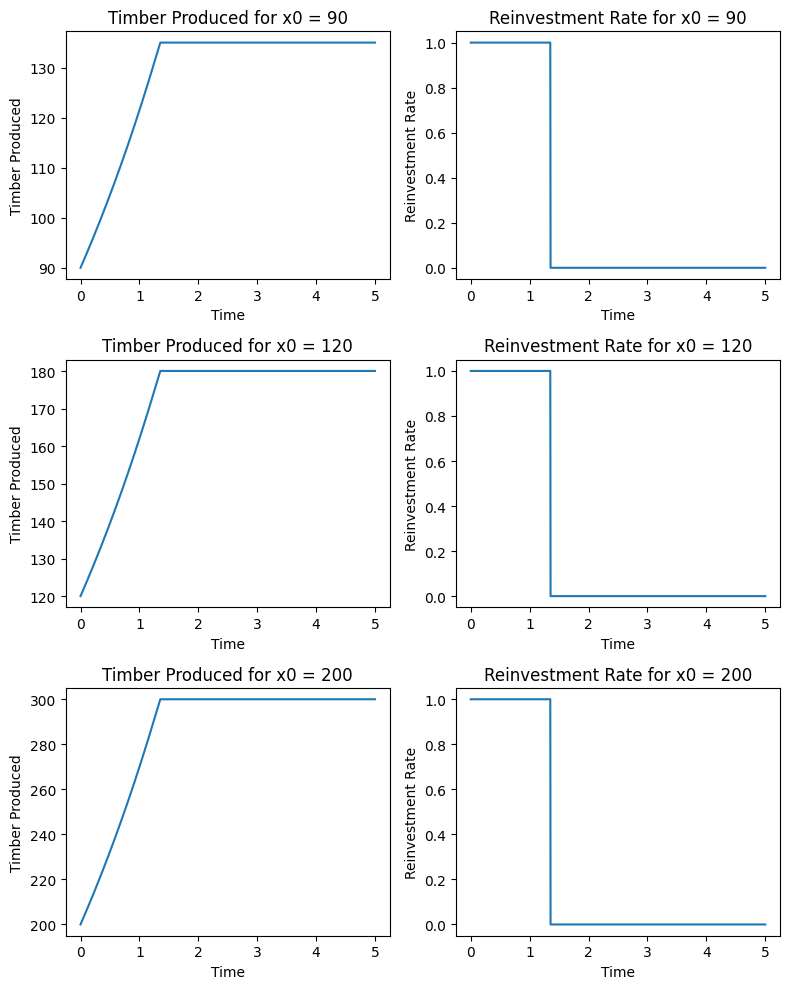

In [39]:
x0s = [90, 120, 200]
k = 0.3
r = 0.05
T = 5

plt.figure(figsize=(8,10))
for i, x0 in enumerate(x0s):
    t, x, u = solve_tree_harvest(x0, k, r, T)

    # plot results
    plt.subplot(3,2, 2*i+1)
    plt.plot(t, x, label='x')
    plt.xlabel('Time')
    plt.ylabel("Timber Produced")
    plt.title("Timber Produced for x0 = {}".format(x0))

    plt.subplot(3, 2, 2*i+2)
    plt.plot(t, u, label='u')
    plt.xlabel('Time')
    plt.ylabel("Reinvestment Rate")
    plt.title("Reinvestment Rate for x0 = {}".format(x0))

plt.tight_layout()
plt.show()

The optimal control does not change no matter the value of x0.